In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecg-dataset/ecg.csv


# ECG Anomaly Detection using Autoencoders

**Problem Statement:**
The objective of anomaly detection in ECG signals is to identify irregularities in heart rates, heartbeats, and rhythms. An effective anomaly detection system should accurately detect anomalies across all heartbeat sequences, providing essential metrics for diagnosing cardiac abnormalities.

An electrocardiogram (ECG) is a diagnostic test that records the electrical activity of the heart. By analyzing ECG signals, healthcare professionals can assess the heart's rhythm and detect any abnormalities such as arrhythmias, ischemia, or conduction disorders.

**Autoencoder:**
Important application of Neural Networks or Deep Learning. It is widely used in dimensionality reduction, image compression, image denoising, and feature extraction. It is also applied in anomaly detection and has delivered superior results.

# Importing Necessary Libraries

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

# Importing necessary functions from scikit-learn for metrics and model selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Importing necessary modules from TensorFlow and Keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Importing UMAP for dimensionality reduction and plotting
import umap
import umap.plot

# Importing Plotly for interactive plots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

2024-04-04 23:11:42.778976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 23:11:42.779104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 23:11:42.938977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-obje

# **Utility Functions**

In [2]:
#function to print evaluation metrics
def get_clf_eval(y_test, pred=None, pred_proba=None):
    # Calculate confusion matrix
    confusion = confusion_matrix(y_test, pred)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # Calculate ROC-AUC if pred_proba is provided
    if pred_proba is not None:
        roc_auc = roc_auc_score(y_test, pred_proba)
        print('ROC-AUC:', roc_auc)
    else:
        roc_auc = None
    
    # Print confusion matrix and evaluation metrics
    print('Confusion Matrix:')
    print(confusion)
    print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))
    
    return confusion, accuracy, precision, recall, f1, roc_auc


In [3]:
# Read the CSV file 'ecg.csv' into a DataFrame named 'dataframe'
dataframe = pd.read_csv('/kaggle/input/ecg-dataset/ecg.csv', header=None)

# Display the first few rows of the DataFrame to inspect the data
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


# **Checking Target Imblance**

In [4]:
# Define the colors for the pie chart slices
colors = ['green', 'red']

# Define the labels for the pie chart slices
labels = ['Normal', 'Abnormal']

# Assuming 'values' contains the proportions for each category
# For example, values = dataframe[140].value_counts() / dataframe[140].shape[0]
values = dataframe[140].value_counts() / dataframe[140].shape[0]


# Create a Pie chart figure using Plotly
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])

# Update the appearance of the pie chart slices and text
fig.update_traces(
    hoverinfo='label+percent',  # Show label and percentage on hover
    textinfo='percent',  # Show percentage on the chart
    textfont_size=20,  # Set the font size of the text
    marker=dict(colors=colors, line=dict(color='white', width=0.1))  # Set colors and outline for slices
)

# display the pie chart
fig.show()

# Splitting Dataset

In [5]:
#we will separate the data and labels
# Assuming raw_data is a NumPy array obtained from the DataFrame
raw_data = dataframe.values

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

# Split the data into training and testing sets
# train_data: training features
# test_data: testing features
# train_labels: labels for training data
# test_labels: labels for testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)


# **Normalization:**
Lets normalize the data to the range (0 to 1)

Formula: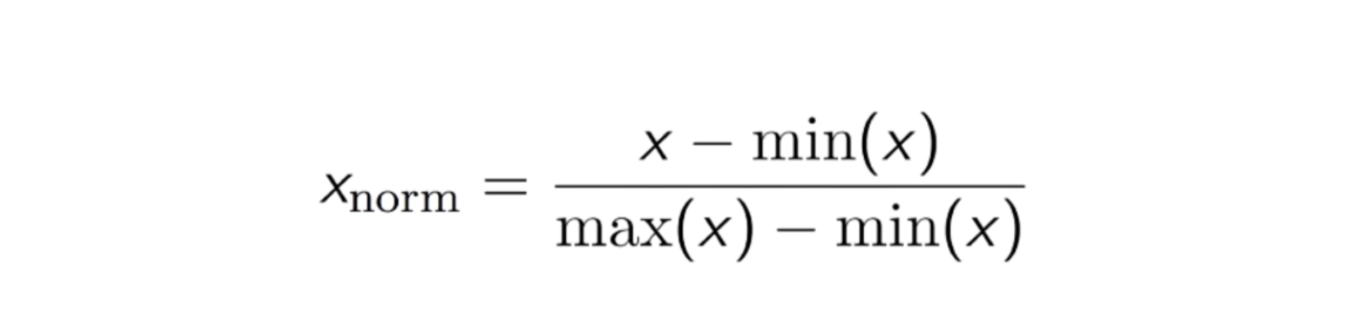


# Preprocessing

In [6]:
# Calculate the maximum and minimum values from the training set
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

# Normalize the data using the formula (data - min)/(max - min)
train_data = (train_data - min) / (max - min)
test_data = (test_data - min) / (max - min)

# Convert the normalized data into float32 data type
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

Training the autoencoder using only the normal rhythm of ECG labeled 1 on this dataset. Separates normal and abnormal rhythms.

In [7]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

#Now let's separate the data for normal ECG from that of abnormal ones
#Normal ECG data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

#Abnormal ECG data
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

#Displaying Normal ECG train data
normal_train_data

the length of train : 3998
the length of test : 1000


<tf.Tensor: shape=(2359, 140), dtype=float32, numpy=
array([[0.57030463, 0.46561658, 0.29058117, ..., 0.48504233, 0.4233502 ,
        0.47598344],
       [0.48320588, 0.28246963, 0.16471253, ..., 0.567567  , 0.4677294 ,
        0.2692329 ],
       [0.48144642, 0.35151404, 0.25972766, ..., 0.5479421 , 0.5077544 ,
        0.54298663],
       ...,
       [0.41039047, 0.24164985, 0.13120876, ..., 0.5277313 , 0.5654091 ,
        0.5023885 ],
       [0.5397748 , 0.4140786 , 0.28101394, ..., 0.51266515, 0.43706053,
        0.4426865 ],
       [0.29639772, 0.15988176, 0.18883787, ..., 0.53766966, 0.545786  ,
        0.40826708]], dtype=float32)>

# Plot normal ECG

Text(0.5, 1.0, 'A Normal ECG')

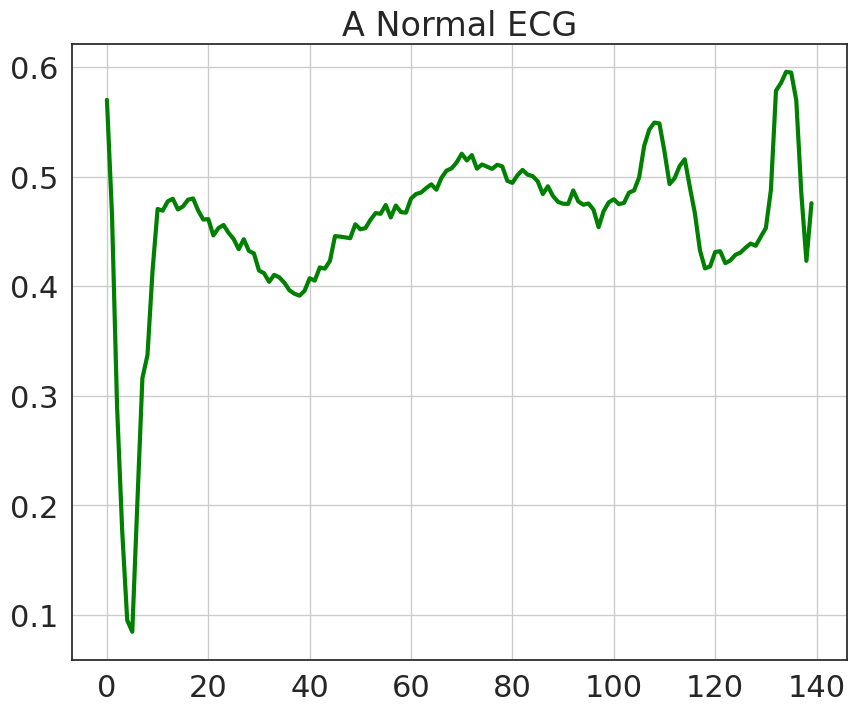

In [8]:
#plotting a normal ECG
# Create a figure for the plot with a specific size
plt.figure(figsize=(10, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Enable gridlines on the plot
plt.grid()

# Plot the ECG data for a normal ECG sample
# Assuming 'normal_train_data[0]' contains the ECG data for a normal sample
plt.plot(np.arange(140), normal_train_data[0], color='green', linewidth=3.0)

# Set the title of the plot
plt.title("A Normal ECG")


# Plot the abnormal ECG

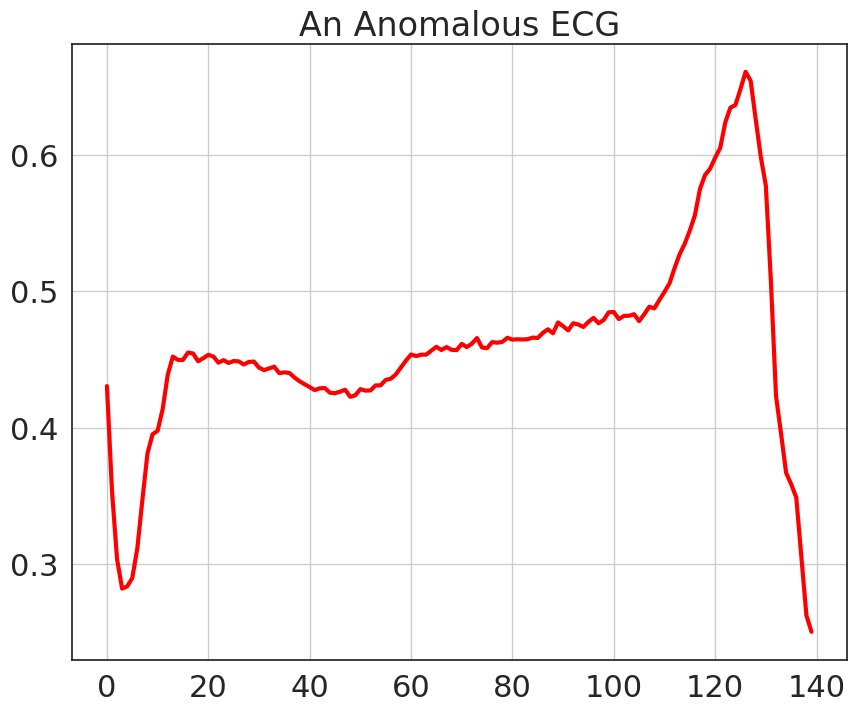

In [9]:
#plotting abnormal ECG
# Create a figure for the plot with a specific size
plt.figure(figsize=(10, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Enable gridlines on the plot
plt.grid()

# Plot the ECG data for an anomalous ECG sample
# Assuming 'anomalous_train_data[0]' contains the ECG data for an anomalous sample
plt.plot(np.arange(140), anomalous_train_data[0], color='red', linewidth=3.0)

# Set the title of the plot
plt.title("An Anomalous ECG")

# Display the plot
plt.show()

# Modeling

In [10]:
#defining the model
#model consist of 2 parts:1.Encoder and 2.Decoder
# Define a custom class AnomalyDetector that inherits from tf.keras.Model
class AnomalyDetector(Model):
    def __init__(self):
        # Initialize the parent class (Model)
        super(AnomalyDetector, self).__init__()

        # Define the encoder layers using a Sequential model
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        # Define the decoder layers using a Sequential model
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")  # Output layer with sigmoid activation
        ])

    # Define the forward pass of the autoencoder model
    def call(self, x):
        encoded = self.encoder(x)  # Encode the input data
        decoded = self.decoder(encoded)  # Decode the encoded data
        return decoded

# Create an instance of the AnomalyDetector class
autoencoder = AnomalyDetector()

In [11]:
# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mae')

# **Training**

The autoencoder is trained using only regular normal ECGs, but evaluated using the full test set.

In [12]:
# Train the autoencoder model
history=autoencoder.fit(
    normal_train_data,  # Input data for training (normal ECG data)
    normal_train_data,  # Target data for training (same as input for reconstruction task)
    epochs=20,  # Number of training epochs
    batch_size=512,  # Batch size for training
    validation_data=(test_data, test_data),  # Validation data for monitoring performance
    shuffle=True  # Shuffle training data before each epoch
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0581 - val_loss: 0.0531
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0561 - val_loss: 0.0513
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0535 - val_loss: 0.0494
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0502 - val_loss: 0.0477
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0466 - val_loss: 0.0460
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428 - val_loss: 0.0439
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0389 - val_loss: 0.0420
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0354 - val_loss: 0.0405
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0324 - val_loss: 0.0392
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0296 - val_loss: 0.0382
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0276 - val_loss: 0.0372
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - val_loss: 0.0365
E

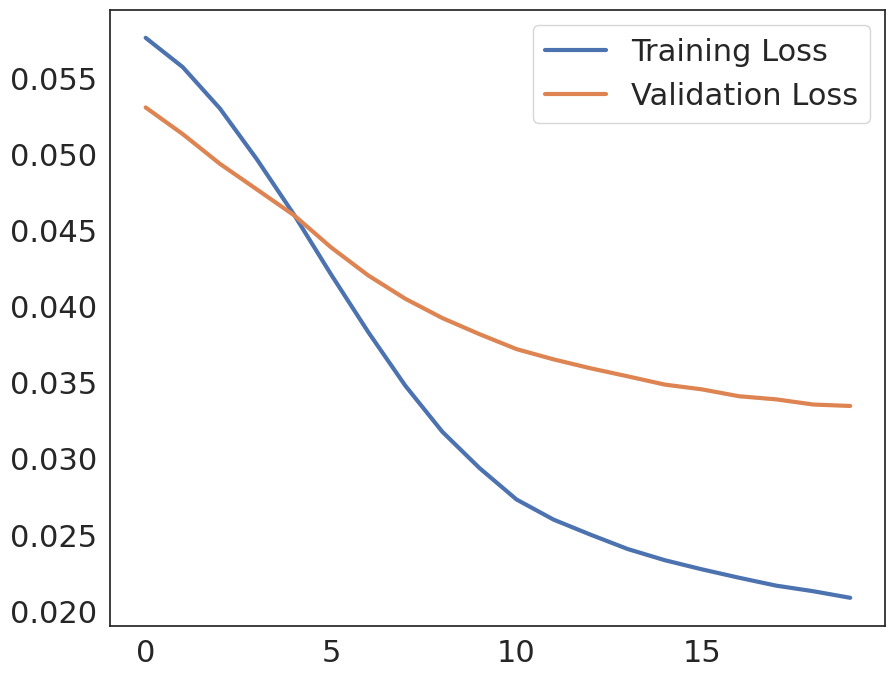

In [13]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

If the reconstruction error is greater than one standard deviation from the normal training example, classify the ECG as abnormal.

# Testing using normal data

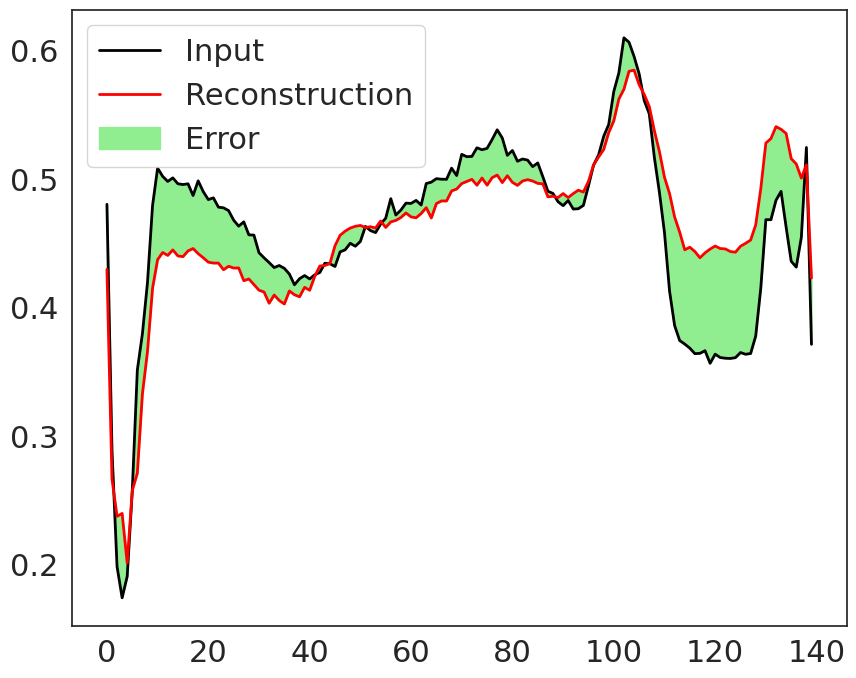

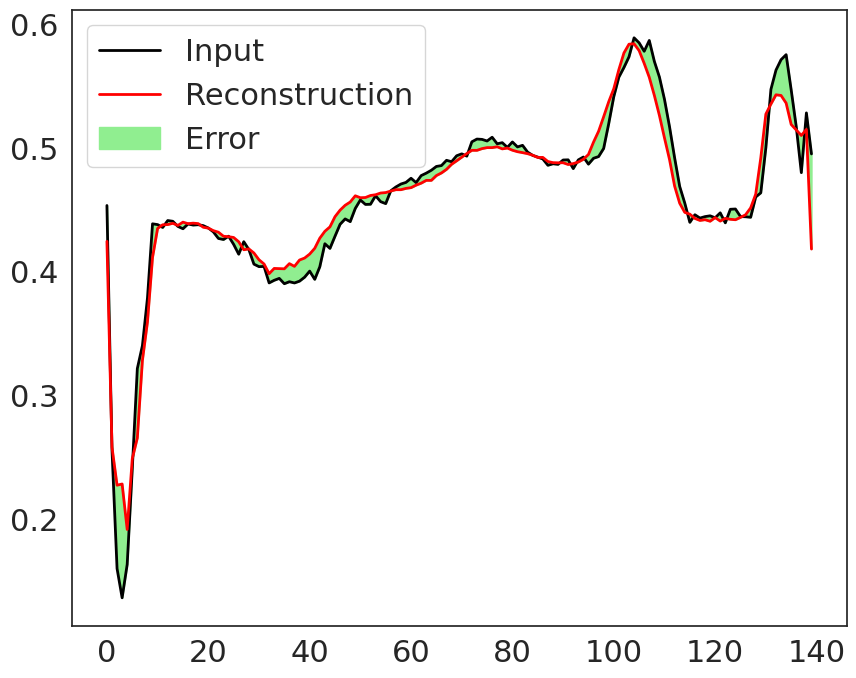

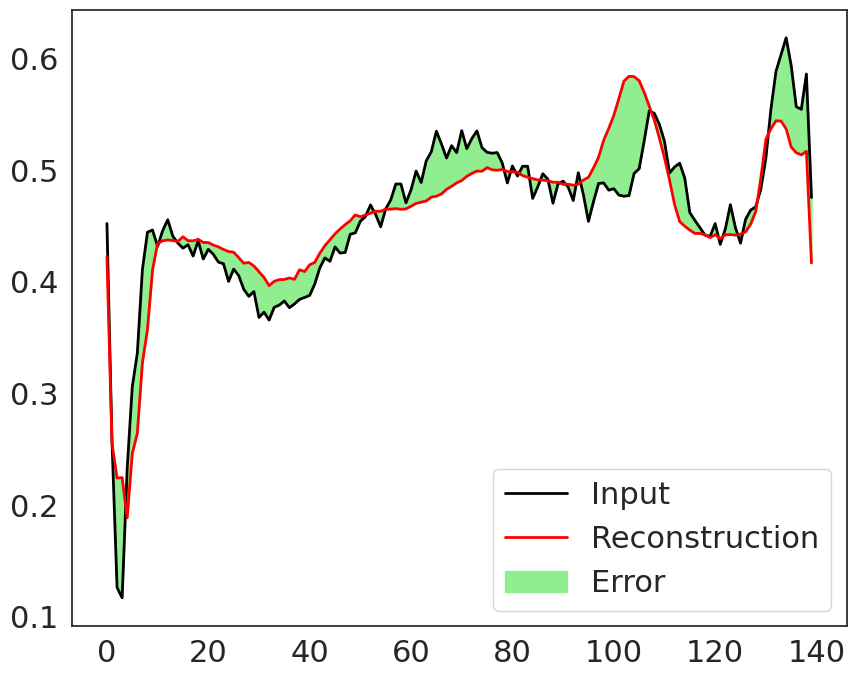

In [14]:
#defining function in order to plot the original ECG and reconstructed ones and also show the error
# Encode the normal test data using the autoencoder's encoder
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()

# Decode the encoded data to obtain the reconstructed images
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Iterate through a few samples for visualization
for i in range(0, 3):
    # Create a figure for the plot with a specific size
    plt.figure(figsize=(10, 8))

    # Set the font scale for better readability in the plot
    sns.set(font_scale=2)

    # Set the plot style to white background
    sns.set_style("white")

    # Plot the original input data (normal ECG)
    plt.plot(normal_test_data[i], 'black', linewidth=2)

    # Plot the reconstructed data from the autoencoder
    plt.plot(decoded_imgs[i], 'red', linewidth=2)

    # Fill the area between the original and reconstructed data to visualize error
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightgreen')

    # Add a legend to the plot
    plt.legend(labels=["Input", "Reconstruction", "Error"])

    # Display the plot
    plt.show()


In [15]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

# **Testing using abnormal data**

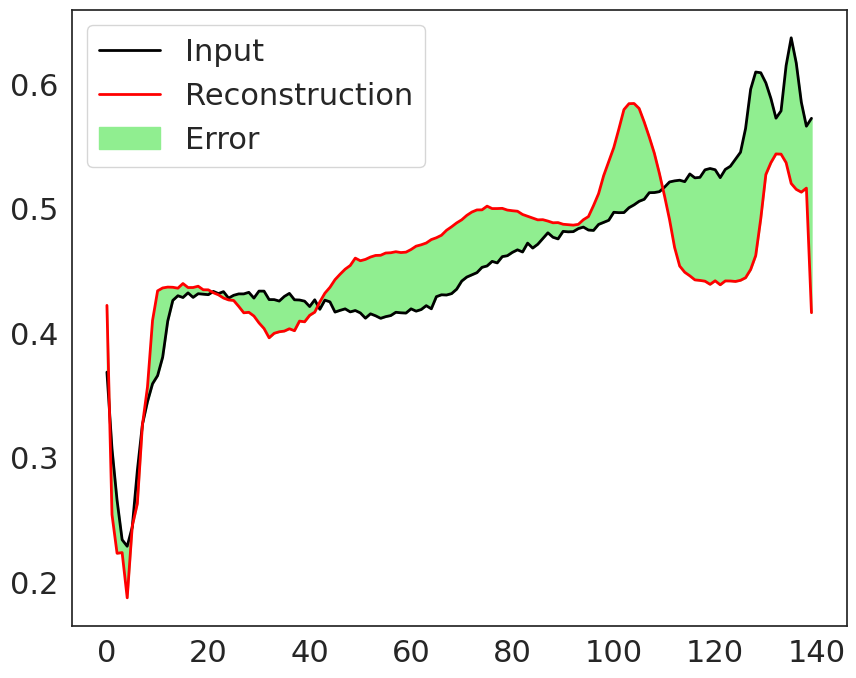

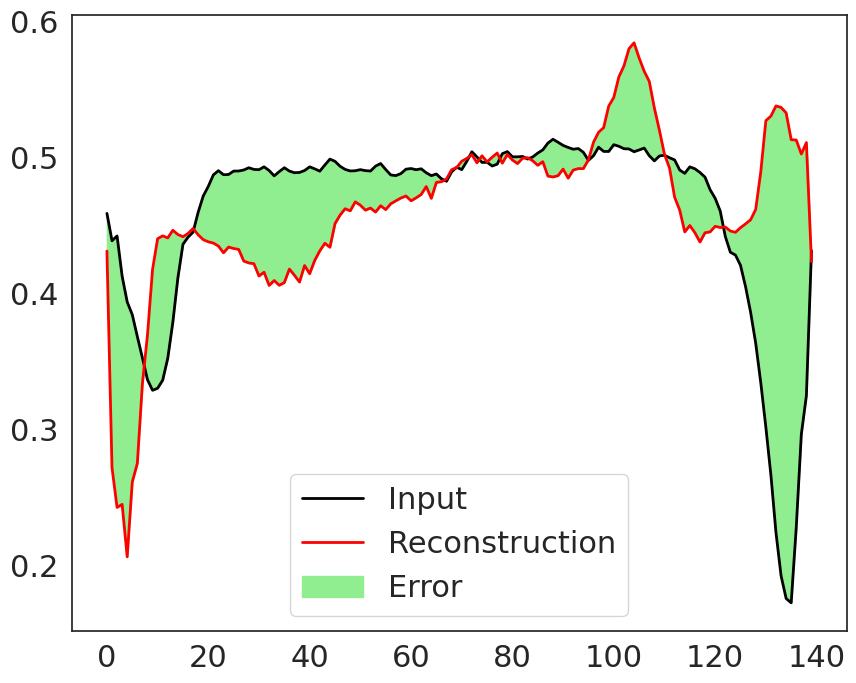

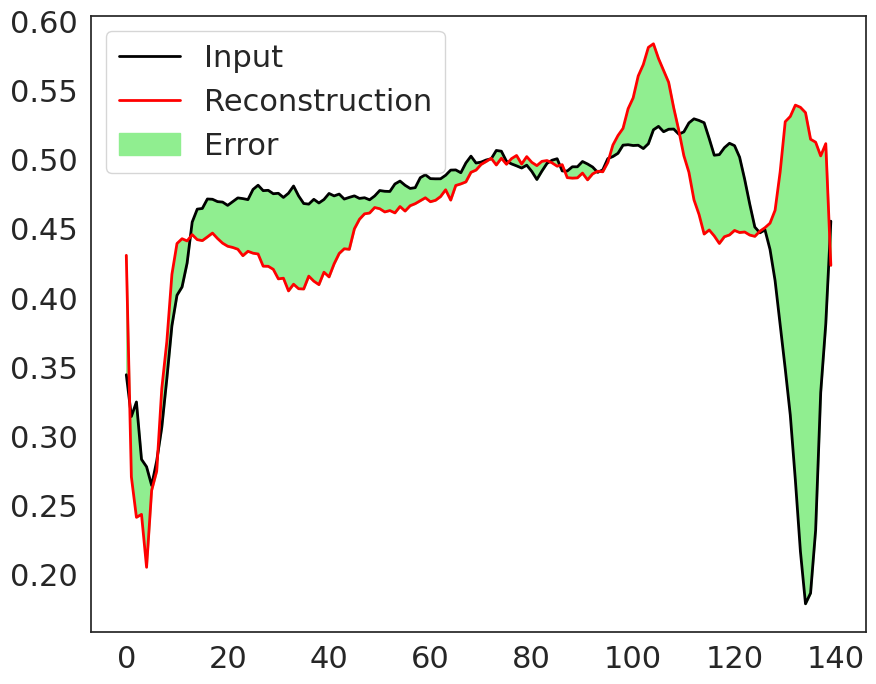

In [16]:
# Encode the anomalous test data using the autoencoder's encoder
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()

# Decode the encoded data to obtain the reconstructed images
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Iterate through a few samples for visualization
for i in range(0, 3):
    # Create a figure for the plot with a specific size
    plt.figure(figsize=(10, 8))

    # Set the font scale for better readability in the plot
    sns.set(font_scale=2)

    # Set the plot style to white background
    sns.set_style("white")

    # Plot the anomalous input data (anomalous ECG) in black
    plt.plot(anomalous_test_data[i], color='black', linewidth=2)

    # Plot the reconstructed data from the autoencoder in red
    plt.plot(decoded_imgs[i], color='red', linewidth=2)

    # Fill the area between the reconstructed and anomalous data to visualize error in light red
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightgreen')

    # Add a legend to the plot
    plt.legend(labels=["Input", "Reconstruction", "Error"])

    # Display the plot
    plt.show()

In [17]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

# **Ploting the Latent Space after Dimension Reduction**

In [18]:
# Concatenate the encoded data for normal and abnormal samples along the rows (axis=0)
all_encoded = pd.concat([encoded_imgs_normal, encoded_imgs_abnormal])

<Axes: >

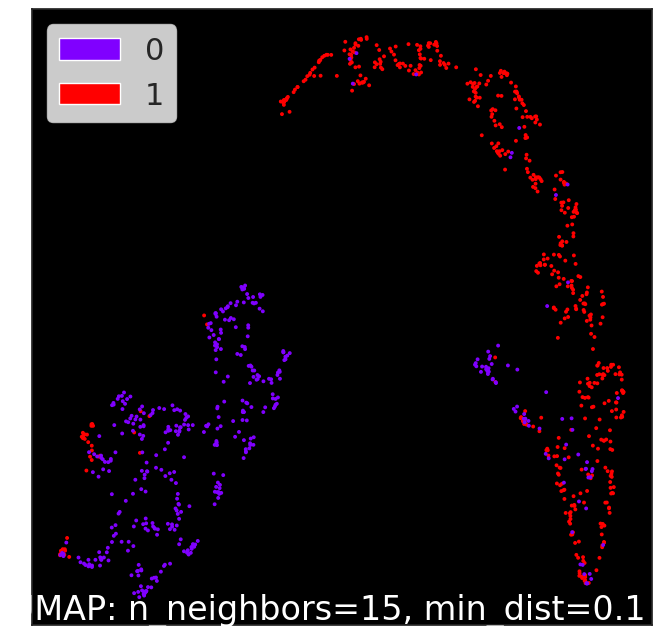

In [19]:
mapper = umap.UMAP().fit(all_encoded.iloc[:,:8])
umap.plot.points(mapper, labels=all_encoded.iloc[:,8], theme='fire')

Observation made from above figures: Dimension Reduction of the latent space for normal and abnormal data. This latent space is a space that has undergone Dimension Reduction by compressing 140-dimensional input into 8-dimensional space. We compressed this space back into two dimensions to obtain the picture above.

It can be confirmed that normal and abnormal data are well separated in the latent space. This is the power of autoencoders, and it can be seen as one of the ways to solve the dimensional curse from the neural network point of view.

# **UMAP connectivity plot**

It works by constructing an intermediate topological representation of the approximate manifold the data may have been sampled from. it can be beneficial to see how that graph looks with respect to the resulting embedding. It can be used to better understand the embedding, and for diagnostic purposes.

<Axes: >

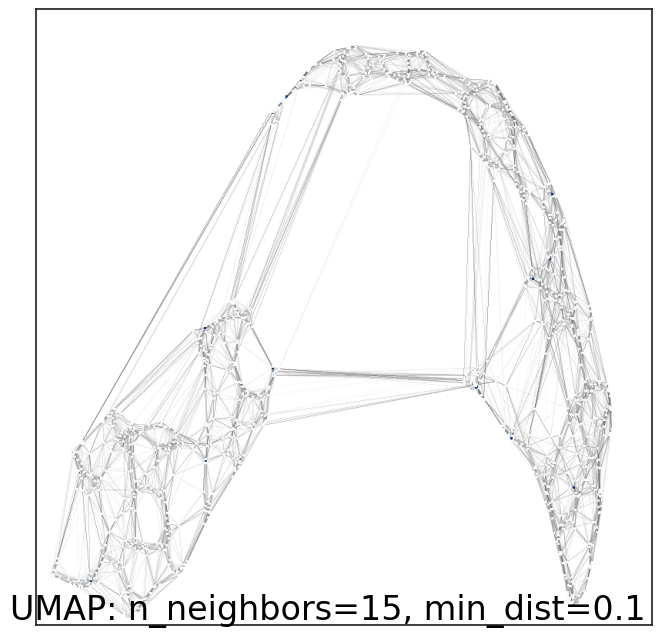

In [49]:
# Plot the connectivity graph using the UMAP mapper
# Set show_points=True to display the points along with the connectivity graph
umap.plot.connectivity(mapper, show_points=True)

# **Detecting Anomaly**

Anomalies are detected by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, we compute the mean error for normal examples in the training set, and then classify future examples as abnormal if the reconstruction error is greater than the standard deviation of the training set.

Plot the reconstruction error for normal ECGs in the training set.

In [50]:
# Generate reconstructions using the autoencoder model
reconstructions = autoencoder.predict(normal_train_data)

# Calculate the Mean Absolute Error (MAE) loss between original and reconstructed data
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [51]:
# Calculate the mean of the training loss values (Mean Absolute Error)
mean_train_loss = np.mean(train_loss)
# displaying mean of training loss
mean_train_loss

0.020671768

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



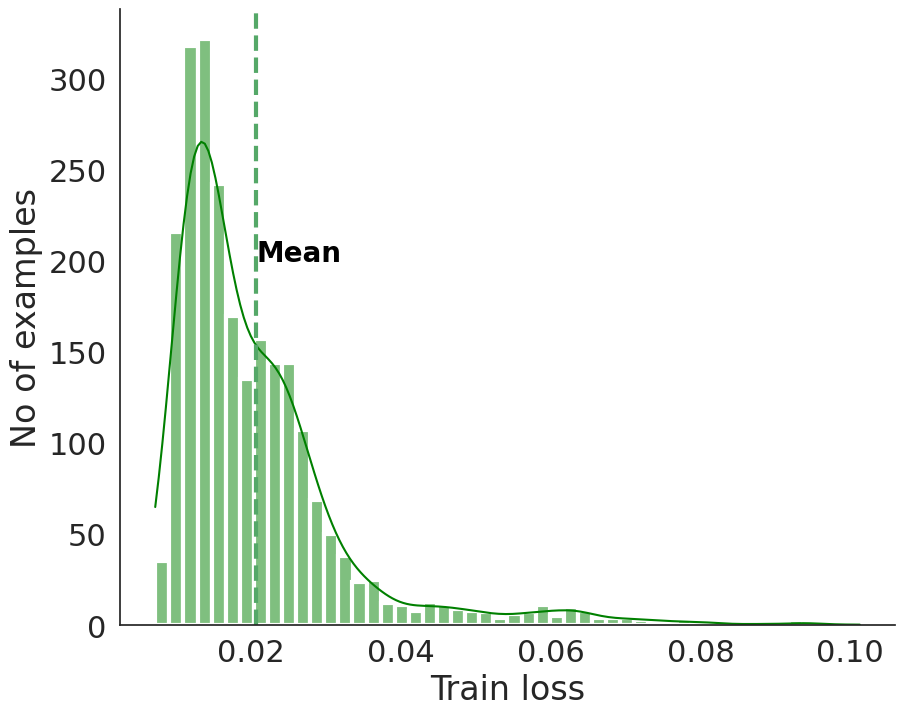

In [52]:
# Create a figure for the histogram plot with a specific size
plt.figure(figsize=(10, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Plot the histogram of training loss values with KDE (Kernel Density Estimate) plot
sns.histplot(train_loss, bins=50, kde=True, color='green', linewidth=3)

# Add a vertical line at the mean of the training loss values
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)

# Add text label for the mean value on the plot
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left', 
         size='small', color='black', weight='semibold')

# Set labels for x and y axes
plt.xlabel("Train loss")
plt.ylabel("No of examples")

# Remove the top and right spines from the plot
sns.despine()

Choosing threshold with a standard deviation greater than mean

In [53]:
# Calculate the threshold as the mean of training loss values plus one standard deviation
threshold = np.mean(train_loss) + np.std(train_loss)

# Print the calculated threshold
print("Threshold: ", threshold)

Threshold:  0.032727037


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



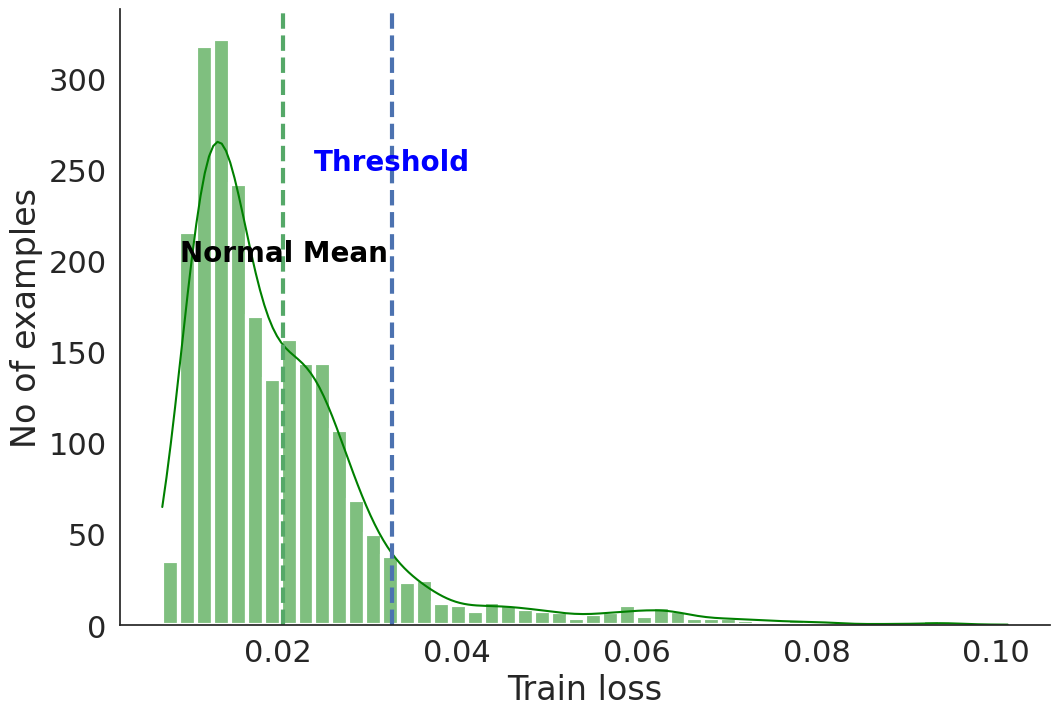

In [54]:
# Create a figure for the histogram plot with a specific size
plt.figure(figsize=(12, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Plot the histogram of training loss values with KDE (Kernel Density Estimate) plot
sns.histplot(train_loss, bins=50, kde=True, color='green', linewidth=3)

# Add a vertical line at the mean of the training loss values (Normal Mean)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)

# Add text label for the mean value on the plot (Normal Mean)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')

# Add a vertical line at the calculated threshold value
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

# Add text label for the threshold value on the plot
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='blue', weight='semibold')

# Set labels for x and y axes
plt.xlabel("Train loss")
plt.ylabel("No of examples")

# Remove the top and right spines from the plot
sns.despine()

**reconstruction errors for unusual examples in the test set reveals that most of them have reconstruction errors greater than the threshold(blue-dotted line=0.033).**

In [55]:
# Generate reconstructions using the autoencoder model for anomalous test data
reconstructions = autoencoder.predict(anomalous_test_data)

# Calculate the Mean Absolute Error (MAE) loss between original and reconstructed data
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



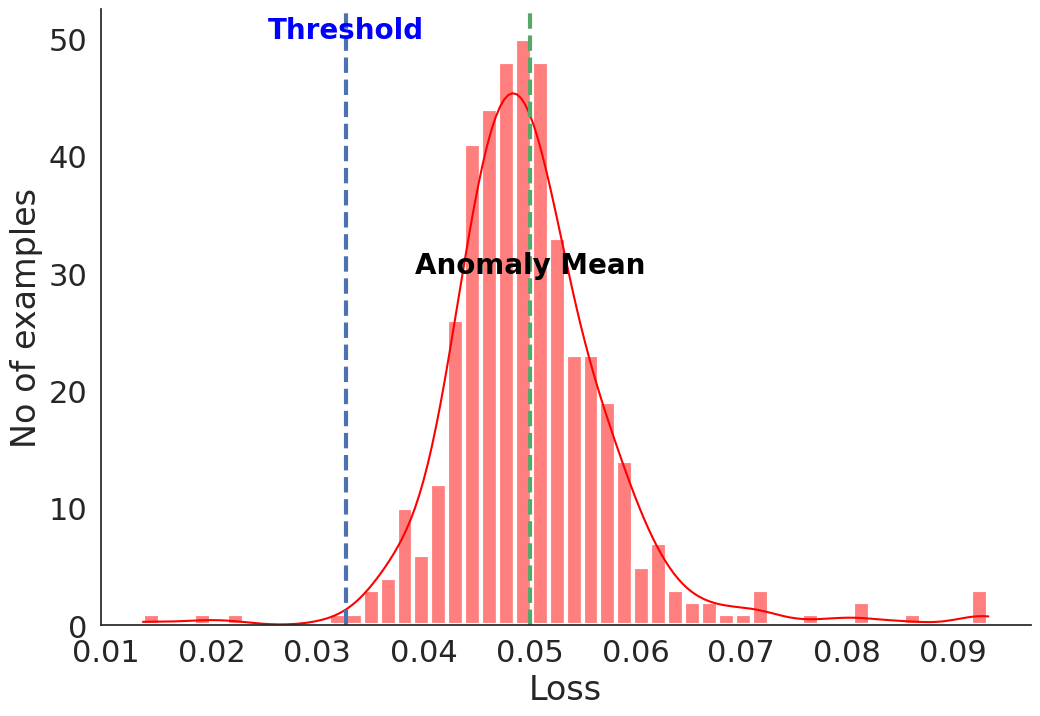

In [56]:
# Create a figure for the histogram plot with a specific size
plt.figure(figsize=(12, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Plot the histogram of test loss values with KDE (Kernel Density Estimate) plot
sns.histplot(test_loss, bins=50, kde=True, color='red', linewidth=3)

# Add a vertical line at the mean of the test loss values (Anomaly Mean)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)

# Add text label for the mean value of test loss on the plot (Anomaly Mean)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')

# Add text label for the threshold value on the plot
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='blue', weight='semibold')

# Add a vertical line at the threshold value
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

# Set labels for x and y axes
plt.xlabel("Loss")
plt.ylabel("No of examples")

# Remove the top and right spines from the plot
sns.despine()

**If the reconstruction error is greater than the threshold(blue-dotted line), classify the ECG as abnormal.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



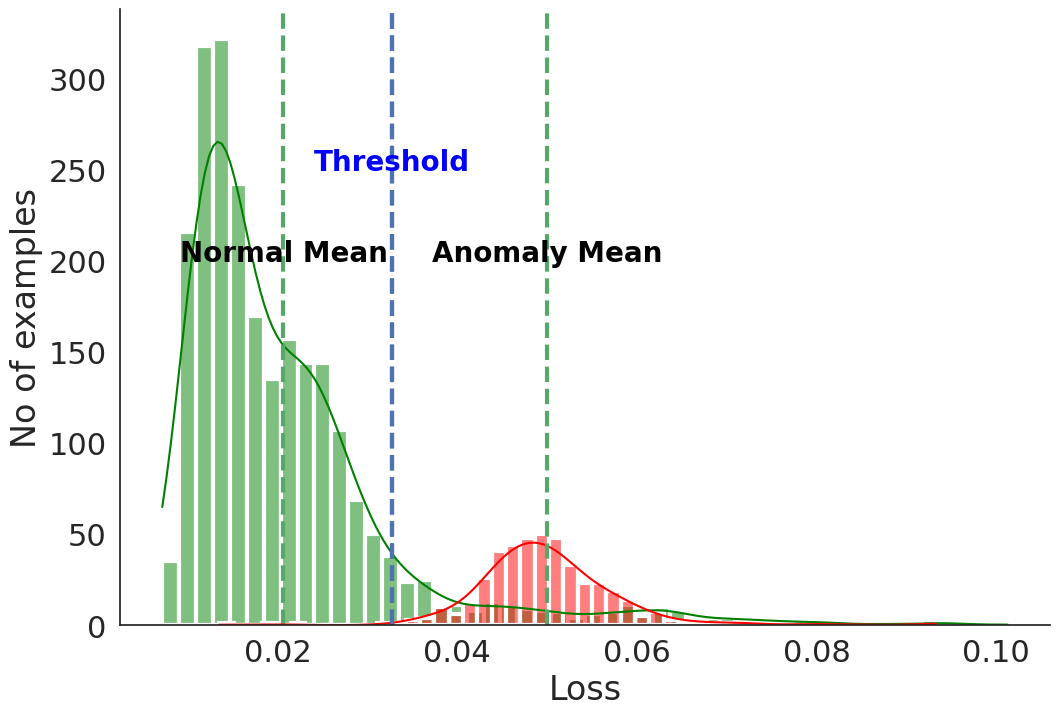

In [57]:
# Create a figure for the histogram plot with a specific size
plt.figure(figsize=(12, 8))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Plot the histogram of training loss values with KDE (Kernel Density Estimate) plot in grey color
sns.histplot(train_loss, bins=50, kde=True, color='green', linewidth=3)

# Add a vertical line at the mean of the training loss values (Normal Mean) in green color
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)

# Add text label for the mean value of training loss on the plot (Normal Mean)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')

# Add a vertical line at the threshold value in blue color
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

# Add text label for the threshold value on the plot
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='blue', weight='semibold')

# Plot the histogram of test loss values with KDE (Kernel Density Estimate) plot in red color
sns.histplot(test_loss, bins=50, kde=True, color='red', linewidth=3)

# Add a vertical line at the mean of the test loss values (Anomaly Mean) in green color
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)

# Add text label for the mean value of test loss on the plot (Anomaly Mean)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')

# Add a vertical line at the threshold value in blue color
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

# Set labels for x and y axes
plt.xlabel("Loss")
plt.ylabel("No of examples")

# Remove the top and right spines from the plot
sns.despine()

From observing the picture above,it seems that the threshold was set by considering the Normal and Anomaly distributions well. In particular, it seems that recall is more important than precision for abnomaly detection. In actual application, it may be necessary to consider fine-tuning the threshold.

# **Prediction**

In [58]:
def predict(model, data, threshold):
    # Generate reconstructions using the model
    reconstructions = model(data)
    
    # Calculate the Mean Absolute Error (MAE) loss between original and reconstructed data
    loss = tf.keras.losses.mae(reconstructions, data)
    
    # Return boolean predictions based on whether loss is less than threshold
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    # Print accuracy, precision, and recall scores based on predictions and actual labels
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [59]:
# Use the predict function to obtain predictions based on the autoencoder model, test data, and threshold
preds = predict(autoencoder, test_data, threshold)

# Print the predictions
print(preds)

# Print statistics (accuracy, precision, recall) based on predictions and actual test labels
print_stats(preds, test_labels)

tf.Tensor(
[False False  True  True False False  True  True False  True False  True
 False  True False  True  True  True False False False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
 False False  True False  True False  True  True  True  True  True False
 False  True  True False False False  True False  True  True False False
 False  True  True False False  True False False  True  True False  True
 False False  True False False  True  True  True  True False False  True
 False  True False False False  True  True False False False  True False
  True False False  True False  True False  True  True  True False  True
 False False  True  True False  True False  True  True False False  True
 False  True  True  True False  True False  True  True False False  True
 False  True False False  True  True  True  True False False False False
 False  True  True  True  True  True False  True  True False  True  True
 False False  True False  True  True  Tr

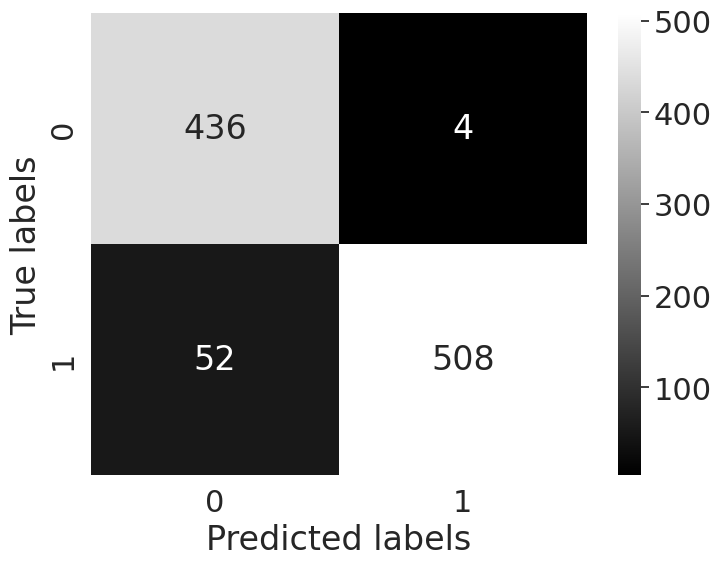

In [60]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)

# Create a figure for the heatmap plot with a specific size
plt.figure(figsize=(8, 6))

# Set the font scale for better readability in the plot
sns.set(font_scale=2)

# Set the plot style to white background
sns.set_style("white")

# Plot the heatmap of the confusion matrix using a specific colormap (gist_yarg_r)
# Annotate cells with the numeric value, and format annotations as integers
sns.heatmap(conf_matrix, cmap='gist_yarg_r', annot=True, fmt='d')

# Add labels for x and y axes
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Display the plot
plt.show()

In [61]:
# Import necessary functions from sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate accuracy using true labels 'test_labels' and predicted labels 'preds'
accuracy = accuracy_score(test_labels, preds)

# Calculate precision using true labels 'test_labels' and predicted labels 'preds'
precision = precision_score(test_labels, preds)

# Calculate recall using true labels 'test_labels' and predicted labels 'preds'
recall = recall_score(test_labels, preds)

# Calculate F1 score using true labels 'test_labels' and predicted labels 'preds'
f1 = f1_score(test_labels, preds)

# Calculate AUC (Area Under the ROC Curve) score using true labels 'test_labels' and predicted labels 'preds'
auc = roc_auc_score(test_labels, preds)

# Print the calculated metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC Score:', auc)

Accuracy: 0.944
Precision: 0.9921875
Recall: 0.9071428571428571
F1 Score: 0.9477611940298508
AUC Score: 0.949025974025974
